# K-means clustering from scratch

# Importing required modules

In [17]:
import numpy as np
from scipy.spatial.distance import cdist 

# Function to implement Kmeans

In [18]:
def kmeans(x,k, no_of_iterations):
    idx = np.random.choice(len(x), k, replace=False)
    #Randomly choosing Centroids 
    centroids = x[idx, :] #Step 1
     
    #finding the distance between centroids and all the data points
    distances = cdist(x, centroids ,'euclidean') #Step 2
     
    #Centroid with the minimum Distance
    points = np.array([np.argmin(i) for i in distances]) #Step 3
     
    #Repeating the above steps for a defined number of iterations
    #Step 4
    for _ in range(no_of_iterations): 
        centroids = []
        for idx in range(k):
            #Updating Centroids by taking mean of Cluster it belongs to
            temp_cent = x[points==idx].mean(axis=0) 
            centroids.append(temp_cent)
 
        centroids = np.vstack(centroids) #Updated Centroids 
         
        distances = cdist(x, centroids ,'euclidean')
        points = np.array([np.argmin(i) for i in distances])
         
    return points, centroids,distances

# Load Digits Data

In [19]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA

data = load_digits().data
target = load_digits().target_names
labels = load_digits().target

pca = PCA(2)
  
#Transform the data
data = pca.fit_transform(data)


# Applying our function

In [20]:
label,centroids,dist = kmeans(data,10,1000)

# Visualize the clustering

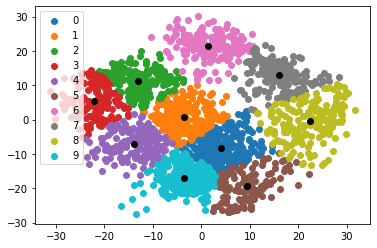

In [21]:
u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)
plt.legend()
plt.scatter(centroids[:,0] ,centroids[:,1], color='black')
plt.show()

# Calculating Clustering Loss

In [22]:
loss  = dist.sum(axis=0)
loss

array([33396.39506751, 31216.19288245, 41102.82517047, 47676.75088288,
       38732.22472221, 46209.64357206, 47302.22110067, 45783.72385696,
       48236.44580165, 40436.41602162])

# Visualize Loss

Text(0, 0.5, 'Loss')

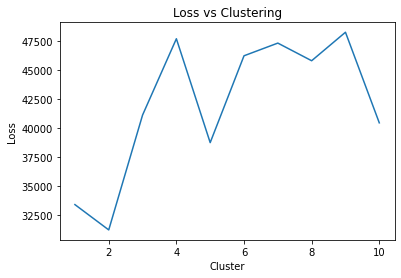

In [23]:
plt.plot(range(1, 11), loss)
plt.title("Loss vs Clustering")
plt.xlabel('Cluster')
plt.ylabel("Loss")

# K-medoids clustering from scratch

# Loading requires modules

In [8]:
from scipy.sparse import csr_matrix
import random

# Function to implement Kmedoids

In [24]:
class KMedoids:
    def __init__(self, n_cluster=10, max_iter=1000, tol=0.0001, start_prob=0.8, end_prob=0.99):
        '''Kmedoids constructor called'''
        if start_prob < 0 or start_prob >= 1 or end_prob < 0 or end_prob >= 1 or start_prob > end_prob:
            raise ValueError('Invalid input')
        self.n_cluster = n_cluster
        self.max_iter = max_iter
        self.tol = tol
        self.start_prob = start_prob
        self.end_prob = end_prob
        
        self.medoids = []
        self.clusters = {}
        self.tol_reached = float('inf')
        self.current_distance = 0
        
        self.__data = None
        self.__is_csr = None
        self.__rows = 0
        self.__columns = 0
        self.cluster_distances = {}
        
        
    def fit(self, data):
        self.__data = data
        self.__set_data_type()     
        self.__start_algo()
        return self
    
    def __start_algo(self):
        self.__initialize_medoids()
        self.clusters, self.cluster_distances = self.__calculate_clusters(self.medoids)
        self.__update_clusters()
 
    def __update_clusters(self):
        for i in range(self.max_iter):
            cluster_dist_with_new_medoids = self.__swap_and_recalculate_clusters()
            if self.__is_new_cluster_dist_small(cluster_dist_with_new_medoids) == True:
                self.clusters, self.cluster_distances = self.__calculate_clusters(self.medoids)
            else:
                break

    def __is_new_cluster_dist_small(self, cluster_dist_with_new_medoids):
        existance_dist = self.calculate_distance_of_clusters()
        new_dist = self.calculate_distance_of_clusters(cluster_dist_with_new_medoids)
        
        if existance_dist > new_dist and (existance_dist - new_dist) > self.tol:
            self.medoids = cluster_dist_with_new_medoids.keys()
            return True
        return False
    
    def calculate_distance_of_clusters(self, cluster_dist=None):
        if cluster_dist == None:
            cluster_dist = self.cluster_distances
        dist = 0
        for medoid in cluster_dist.keys():
            dist += cluster_dist[medoid]
        return dist
        
    def __swap_and_recalculate_clusters(self):
        cluster_dist = {}
        for medoid in self.medoids:
            is_shortest_medoid_found = False
            for data_index in self.clusters[medoid]:
                if data_index != medoid:
                    cluster_list = list(self.clusters[medoid])
                    cluster_list[self.clusters[medoid].index(data_index)] = medoid
                    new_distance = self.calculate_inter_cluster_distance(data_index, cluster_list)
                    if new_distance < self.cluster_distances[medoid]:
                        cluster_dist[data_index] = new_distance
                        is_shortest_medoid_found = True
                        break
            if is_shortest_medoid_found == False:
                cluster_dist[medoid] = self.cluster_distances[medoid]
        return cluster_dist
    
    def calculate_inter_cluster_distance(self, medoid, cluster_list):
        distance = 0
        for data_index in cluster_list:
            distance += self.__get_distance(medoid, data_index)
        return distance/len(cluster_list)
        
    def __calculate_clusters(self, medoids):
        clusters = {}
        cluster_distances = {}
        for medoid in medoids:
            clusters[medoid] = []
            cluster_distances[medoid] = 0
            
        for row in range(self.__rows):
            nearest_medoid, nearest_distance = self.__get_shortest_distance_to_mediod(row, medoids)
            cluster_distances[nearest_medoid] += nearest_distance
            clusters[nearest_medoid].append(row)
        
        for medoid in medoids:
            cluster_distances[medoid] /= len(clusters[medoid])
        return clusters, cluster_distances
        
        
    def __get_shortest_distance_to_mediod(self, row_index, medoids):
        min_distance = float('inf')
        current_medoid = None
        
        for medoid in medoids:
            current_distance = self.__get_distance(medoid, row_index)
            if current_distance < min_distance:
                min_distance = current_distance
                current_medoid = medoid
        return current_medoid, min_distance

    def __initialize_medoids(self):
        self.medoids.append(random.randint(0,self.__rows-1))
        while len(self.medoids) != self.n_cluster:
            self.medoids.append(self.__find_distant_medoid())
    
    def __find_distant_medoid(self):
        distances = []
        indices = []
        for row in range(self.__rows):
            indices.append(row)
            distances.append(self.__get_shortest_distance_to_mediod(row,self.medoids)[1])
        distances_index = np.argsort(distances)
        choosen_dist = self.__select_distant_medoid(distances_index)
        return indices[choosen_dist]
    
    def __select_distant_medoid(self, distances_index):
        start_index = round(self.start_prob*len(distances_index))
        end_index = round(self.end_prob*(len(distances_index)-1)) 
        return distances_index[random.randint(start_index, end_index)]

                           
    def __get_distance(self, x1, x2):
        a = self.__data[x1].toarray() if self.__is_csr == True else np.array(self.__data[x1])
        b = self.__data[x2].toarray() if self.__is_csr == True else np.array(self.__data[x2])
        return np.linalg.norm(a-b)
    
    def __set_data_type(self):
        '''to check whether the given input is of type "list" or "csr" '''
        if isinstance(self.__data,csr_matrix):
            self.__is_csr = True
            self.__rows = self.__data.shape[0]
            self.__columns = self.__data.shape[1]
        elif isinstance(self.__data,list):
            self.__is_csr = False
            self.__rows = len(self.__data)
            self.__columns = len(self.__data[0])
        else:
            raise ValueError('Invalid input')

# Load Digits Data

In [25]:
X = data
data = data.tolist()

# Applying our function

In [26]:
k_medoids = KMedoids(n_cluster=10)
k_medoids.fit(data)

# Visualize the clustering

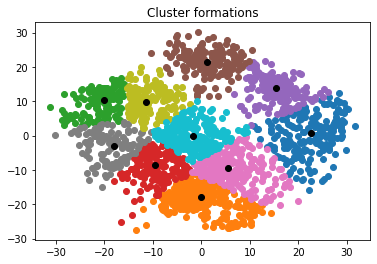

In [27]:
def plot_graphs(data, k_medoids):
    for key in k_medoids.clusters.keys():
        temp_data = k_medoids.clusters[key]
        x = [data[i][0] for i in temp_data]
        y = [data[i][1] for i in temp_data]
        plt.scatter(x,y)
    plt.title('Cluster formations')
    #plt.show()

    medoid_data_points = []
    for m in k_medoids.medoids:
        medoid_data_points.append(data[m])   
    x = [i[0] for i in data]
    y = [i[1] for i in data]
    x_ = [i[0] for i in medoid_data_points]
    y_ = [i[1] for i in medoid_data_points]
    plt.plot(x_, y_,'ko')
    plt.show()
    
plot_graphs(data, k_medoids)

# Calculating Clustering Loss

In [28]:
n_clusters = range(1,11)
k_medoids = [KMedoids(n_cluster=i) for i in n_clusters]
k_medoids = [k_medoid.fit(data) for k_medoid in k_medoids]
loss = [k_medoid.calculate_distance_of_clusters() for k_medoid in k_medoids]

# Visualize Loss

Text(0.5, 1.0, 'Loss Vs clusters')

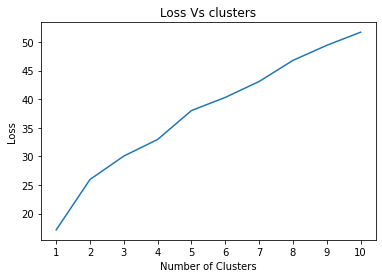

In [29]:
plt.plot(n_clusters,loss)
plt.xticks(n_clusters)
plt.xlabel('Number of Clusters')
plt.ylabel('Loss')
plt.title('Loss Vs clusters')

# Comment:

We see performance of K-means is better. Since the loss of k-means is decreasing where the loss of k-medoids is increasing.